In [1]:
# Please keep confidential at this time. While we are going to open source the main contracts, we would like this to remain inside the team until then.

# REQUIREMENTS
# uncomment and run any that you dont have installed
#!pip install sympy
#!pip install numpy
#!pip install plotly
import numpy as np
from sympy import * # For symbolic maths
import plotly.graph_objects as go
import math
import itertools
init_printing()

from tqdm import tqdm

In [18]:
num=100 # percision of search space; i.e. 100 = 1% iterations, 1000 = 0.1% iterations. 100 is performant. breaks down performance wise around 300
#b_0, b_1, b_2, c_1, d_2, p,r_1, s_0, s_2, t_1, x, y, z, lam = symbols('b_0, b_1, b_2, c_1, d, p,r_1, s_0, s_2, t_1, x, y, z, lam ')
#BASE = 10**18 

## VARIABLES
# We are dividing by BASE in all of these to scale down to easy-to-reason about allocations of 0% to 100% allocation of total capital
# Each of these can be changed as you want to explore different variations
# If t_1 is very high you run into vanishing gradient issues, but thats because at super high capital amounts, it doesnt matter
# as much where you put the capital because rates will tend toward 0 because we don't vary the borrowing proportionally.

t = 10000000 #/ BASE # totalCapital 1e24/BASE == 1,000,000 
# While we are using a low capital amount, this is just to have an easily understandable showcase example. Increase capital amounts here to test larger sums, but
# be aware of the above comment regarding vanishing gradients and in this model not changing borrow side proportionately

d_s= 200000000
b_s= 140000000
d_p= 23000000
b_p= 10000000
d_j= 7600000
b_j= 7000000

x, y, z = symbols("x, y, z")
a_s = x * t
a_p = y * t
a_j = z * t

u_s = b_s / (d_s + a_s)
u_p = b_p / (d_p + a_p)
u_j = b_j / (d_j + a_j)

solend_borrow = Piecewise((0.1*u_s, u_s < 0.8), (2.1*u_s-1.6, u_s >= 0.8))
port_borrow = Piecewise((3*u_p/40, u_p < 0.8), (3.6*u_p-2.8, u_p >= 0.8))
jet_borrow = Piecewise((11*u_j/170+.005, u_j < 0.85), (3.4*u_j-2.83, u_j >= 0.85), (24*u_j-22.4, u_j>=0.95))

solend_rate = solend_borrow*u_s*x
port_rate = port_borrow*u_p*y
jet_rate = jet_borrow*u_j*z

In [19]:
print(solend_rate)
print(port_rate)
print(jet_rate)

140000000*x*Piecewise((14000000.0/(10000000*x + 200000000), 1/(10000000*x + 200000000) < 5.71428571428571e-9), (-1.6 + 294000000.0/(10000000*x + 200000000), True))/(10000000*x + 200000000)
10000000*y*Piecewise((750000/(10000000*y + 23000000), 1/(10000000*y + 23000000) < 8.0e-8), (-2.8 + 36000000.0/(10000000*y + 23000000), True))/(10000000*y + 23000000)
7000000*z*Piecewise((0.005 + 7700000/(17*(10000000*z + 7600000)), 1/(10000000*z + 7600000) < 1.21428571428571e-7), (-2.83 + 23800000.0/(10000000*z + 7600000), True))/(10000000*z + 7600000)


In [20]:
# 1xN Matrix addition, with rounding
def matPlus(a,b):
    c = []
    for i in range(len(a)):
        c.append(round(a[i]+b[i], 3))
    return c

# 1xN Matrix subtraction, with rounding
def matMinus(a,b):
    c = []
    for i in range(len(a)):
        c.append(round(a[i]-b[i], 3))
    return c

# 1xN Matrix scalar multiplication
def matMulScalar(c,a):
    b = []
    for i in range(len(a)):
        b.append(a[i]*c)
    return b

# 1xN Matrix dot product
def dot(a,b):
    c = 0
    for i in range(3):
        c += a[i]*b[i]
    return c

# point to line projection for when projection is still not in the plane
def pointLineProj(a,b,p):
    ap = matMinus(p,a)
    ab = matMinus(b,a)
    return matPlus(a, matMulScalar((dot(ap,ab) / dot(ab,ab)),ab))



# Just a color map, ignore
pl_curl=[[0.0, 'rgb(20, 29, 67)'],# curl is a cmocean colormap 
         [0.05, 'rgb(25, 52, 80)'],
         [0.1, 'rgb(28, 76, 96)'],
         [0.15, 'rgb(23, 100, 110)'],
         [0.2, 'rgb(16, 125, 121)'],
         [0.25, 'rgb(44, 148, 127)'],
         [0.3, 'rgb(92, 166, 133)'],
         [0.35, 'rgb(140, 184, 150)'],
         [0.4, 'rgb(182, 202, 175)'],
         [0.45, 'rgb(220, 223, 208)'],
         [0.5, 'rgb(253, 245, 243)'],
         [0.55, 'rgb(240, 215, 203)'],
         [0.6, 'rgb(230, 183, 162)'],
         [0.65, 'rgb(221, 150, 127)'],
         [0.7, 'rgb(211, 118, 105)'],
         [0.75, 'rgb(194, 88, 96)'],
         [0.8, 'rgb(174, 63, 95)'],
         [0.85, 'rgb(147, 41, 96)'],
         [0.9, 'rgb(116, 25, 93)'],
         [0.95, 'rgb(82, 18, 77)'],
         [1.0, 'rgb(51, 13, 53)']]
ns = []
for i in pl_curl:
    ns.append(i[0])
ns = ns[::-1]
for i in range(len(pl_curl)):
    pl_curl[i][0] = ns[i]
pl_curl = pl_curl[::-1]   

combos = []
# this function creates the search space combinations such that x+y+z = 1. Not used in optimization, just for visualization purposes
def partitions(n, k):
    for c in itertools.combinations(range(n+k-1), k-1):
        yield [b-a-1 for a, b in zip((-1,)+c, c+(n+k-1,))]

for par in partitions(num, 3):
    combos.append(par)
    
returnMap = {}   

def calcAPR(x_,y_,z_, lr=2):
    s, p, j = solend_rate, port_rate, jet_rate
    dxv = s.subs([(x,x_)]) # substitute in the given x percentage to contribution function
    dyv = p.subs([(y,y_)])
    dzv = j.subs([(z,z_)])
    xV = diff(s,x).subs([(x,x_)]) # take the derivative and evaluate percentage
    yV = diff(p,y).subs([(y,y_)])
    zV = diff(j,z).subs([(z,z_)])

    #gradient descent
    nX = x_+lr*xV
    nY = y_+lr*yV
    nZ = z_+lr*zV

    # distance from constraint plane given that the normal of the plane is 1, therefore unit normal vector is sqrt(3)/3
    xdist = (nX-x_)*(math.sqrt(3)/3)
    ydist = (nY-y_)*(math.sqrt(3)/3)
    zdist = (nZ-z_)*(math.sqrt(3)/3)

    # total euclidean distance
    dist = xdist + ydist + zdist

    # Distance to constraint plane
    vn = dist*math.sqrt(3)/3

    # Projection down onto the plane
    projX = nX - vn
    projY = nY - vn
    projZ = nZ - vn

    # Edge case handling where projects onto plane but is still outside constraint space
    # instead of doing projection onto plane, performs projection onto line along f(x,y), f(x,z), or f(y,z)
    # i.e. projection was -.1, 1.1, 0 -> needs to be flattened further into constraint boundary line
    if projZ < 0:
        #project onto boundary line
        projV = pointLineProj([1,0,0],[0,1,0], [nX,nY,nZ])
        for i in range(3):
            if projV[i] < 0:
                projV[i] = 0
            if projV[i] > 1:
                projV[i] = 1
        projX = projV[0]
        projY = projV[1]
        projZ = projV[2]

    if projX < 0:
        projV = pointLineProj([0,1,0],[0,0,1], [projX,projY,projZ])
        for i in range(3):
            if projV[i] < 0:
                projV[i] = 0
            if projV[i] > 1:
                projV[i] = 1
        projX = projV[0]
        projY = projV[1]
        projZ = projV[2]

    if projY < 0:
        projV = pointLineProj([1,0,0],[0,0,1], [projX,projY,projZ])
        for i in range(3):
            if projV[i] < 0:
                projV[i] = 0
            if projV[i] > 1:
                projV[i] = 1
        projX = projV[0]
        projY = projV[1]
        projZ = projV[2]

    # APR, gradX, gradY, gradZ, offConstraintPlaneX, offConstraintPlaneY, offConstraintPlaneZ, projectedOnConstraintPlaneX, projectedOnConstraintPlaneY, projectedOnConstraintPlaneZ
    return float(dxv + dyv + dzv), float(xV), float(yV), float(zV), float(nX), float(nY), float(nZ), float(projX), float(projY), float(projZ)


In [21]:
xs = []
ys = []
zs = []
u = []
v = []
w = []
x2s = []
y2s = []
z2s = []
cs = []


# data processing for visualization
for i in tqdm(range(len(combos))):
    for j in range(len(combos[i])):
        combos[i][j] = combos[i][j] / num
    APR, ui, vi, wi,x2, y2, z2, projX, projY,projZ  = calcAPR(combos[i][0],combos[i][1],combos[i][2])    
    u.append(ui)
    v.append(vi)
    w.append(wi)
    x2s.append(projX)
    y2s.append(projY)
    z2s.append(projZ)
    x2s.append(x2)
    y2s.append(y2)
    z2s.append(z2)
    cs.append(APR)
    cs.append(APR)
    returnMap[i] = {"APR":APR, "x":combos[i][0], "y":combos[i][1], "z":combos[i][2]}
    
for i in returnMap:
    xs.append(returnMap[i]["x"])
    ys.append(returnMap[i]["y"])
    zs.append(returnMap[i]["z"])
#    cs.append(returnMap[i]["APR"])
dots = go.Scatter3d(
    x=x2s,
    y=y2s,
    z=z2s,
    marker=dict(size=4,color=cs, colorscale=pl_curl),
    mode="markers"
)

cones = dict(type='cone',
    x=xs,
    y=ys, 
    z=zs, 
    u=u, 
    v=v, 
    w=w, 
    sizemode='scaled',
    cauto=False,
    sizeref=2,
    #               showscale=True,
    #               colorscale=pl_curl, 
    #               colorbar=dict(thickness=20, ticklen=4, len=0.75), 
    anchor='tail'
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5151/5151 [00:21<00:00, 243.41it/s]


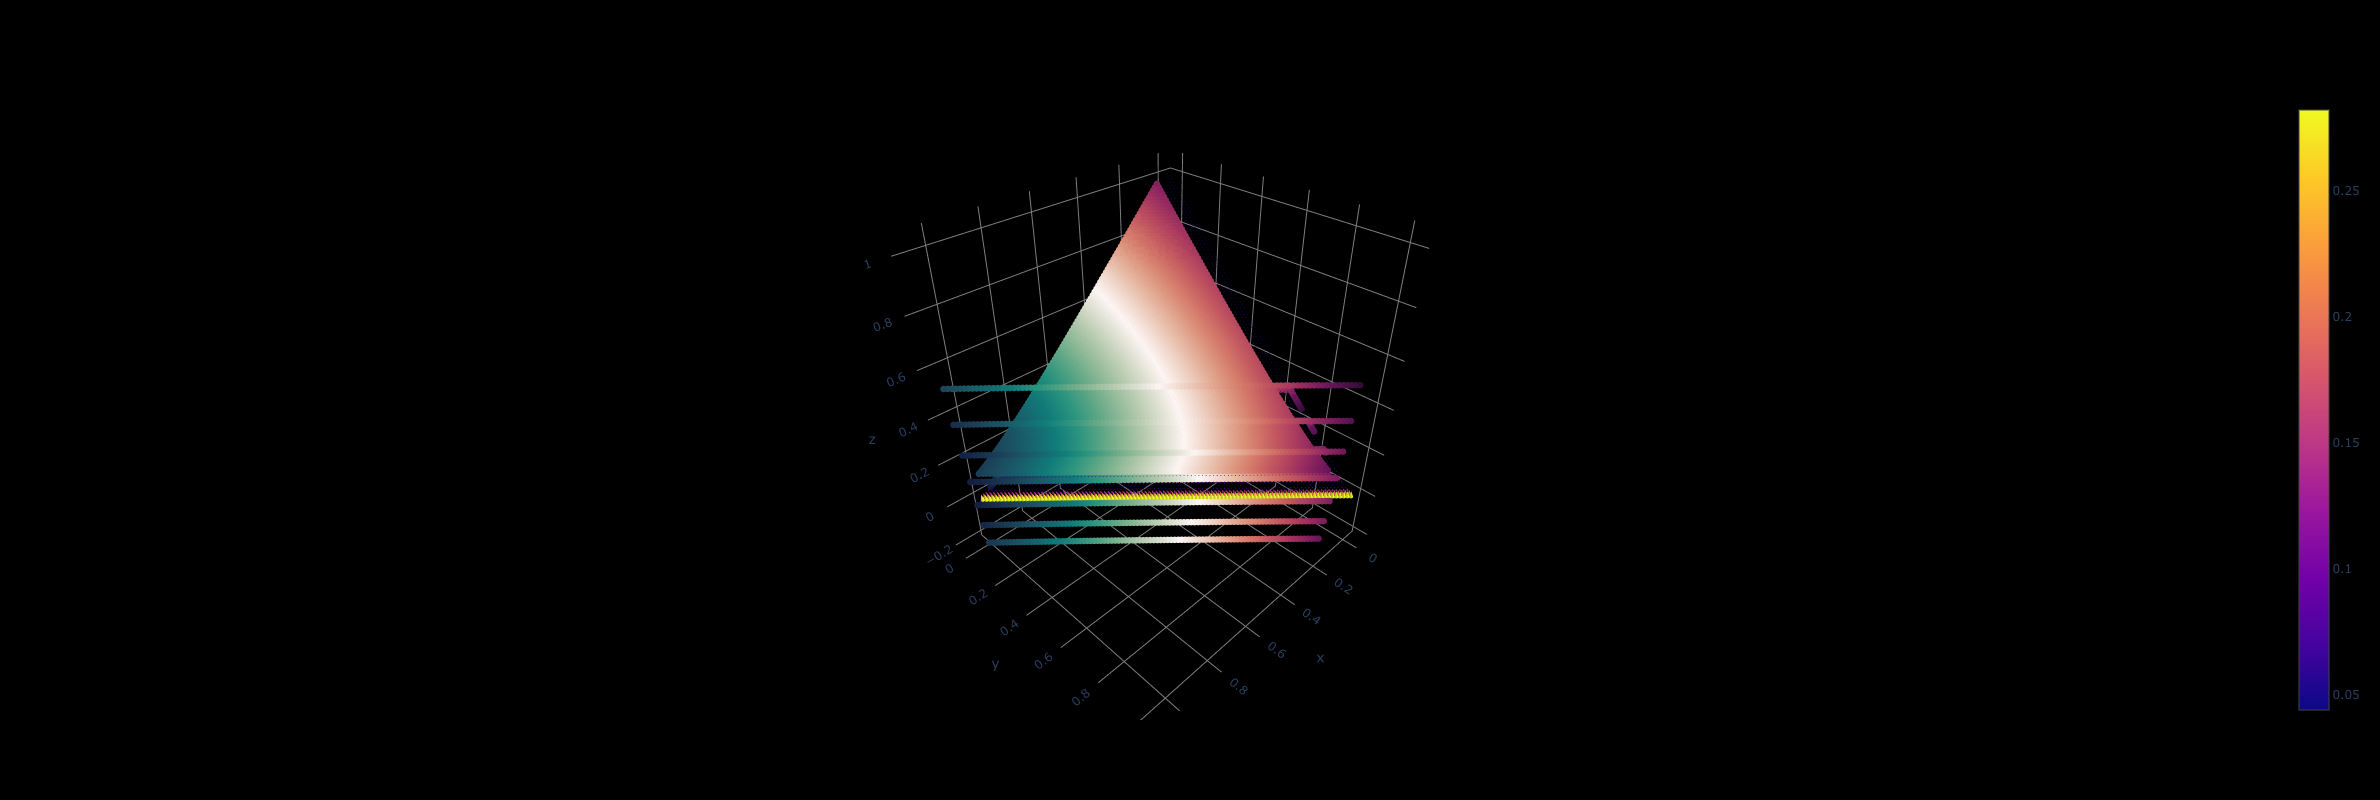

In [22]:
fig = go.Figure(data=[cones,dots])
fig.update_layout(
    width=1200, #adjust this if you are not using a jupyter-themes notebook w/ cell-width set to 100% of window
    height=800,
    paper_bgcolor="black",
    scene = dict(
                    xaxis = dict(
                         backgroundcolor="black",
                         gridcolor="rgb(128,128,128)",
                         showbackground=True,
                         zerolinecolor="rgb(128,128,128)",),
                    yaxis = dict(
                        backgroundcolor="black",
                        gridcolor="rgb(128,128,128)",
                        showbackground=True,
                        zerolinecolor="rgb(128,128,128)"),
                    zaxis = dict(
                        backgroundcolor="black",
                        gridcolor="rgb(128,128,128)",
                        showbackground=True,
                        zerolinecolor="rgb(128,128,128)",),)
)
fig.show()   

<p>Quick explanation: the furthest back triangle (filled with purple to yellow cones) are the calculated gradients at search_space_stepsize = 1%. The green/white/magenta triangle consists of points that result from the gradient*learningRate + current_(x,y,z). As you can see, these are off the constraint plane. Therefore we need to find the closest point on the constraint plane via projection. The green/white/magenta on the triangle are the projected points.</p><br><br>


<h2>Graph 2 </h2>
<p> for this graph, we want to evaluate how well we are optimizing. Based on the above graph, which is a brute force search of the entire space, we want to take a subset. This next one chooses 50 random start points and shows how they optimize at each iteration. Note: each one of these 50 are sufficient. 50 are chosen to showcase convergence across the search space (i.e. given the worst possible allocation, how well can we do?). In reality, only one of these lines happens and needs to be calculated. </p>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.28it/s]


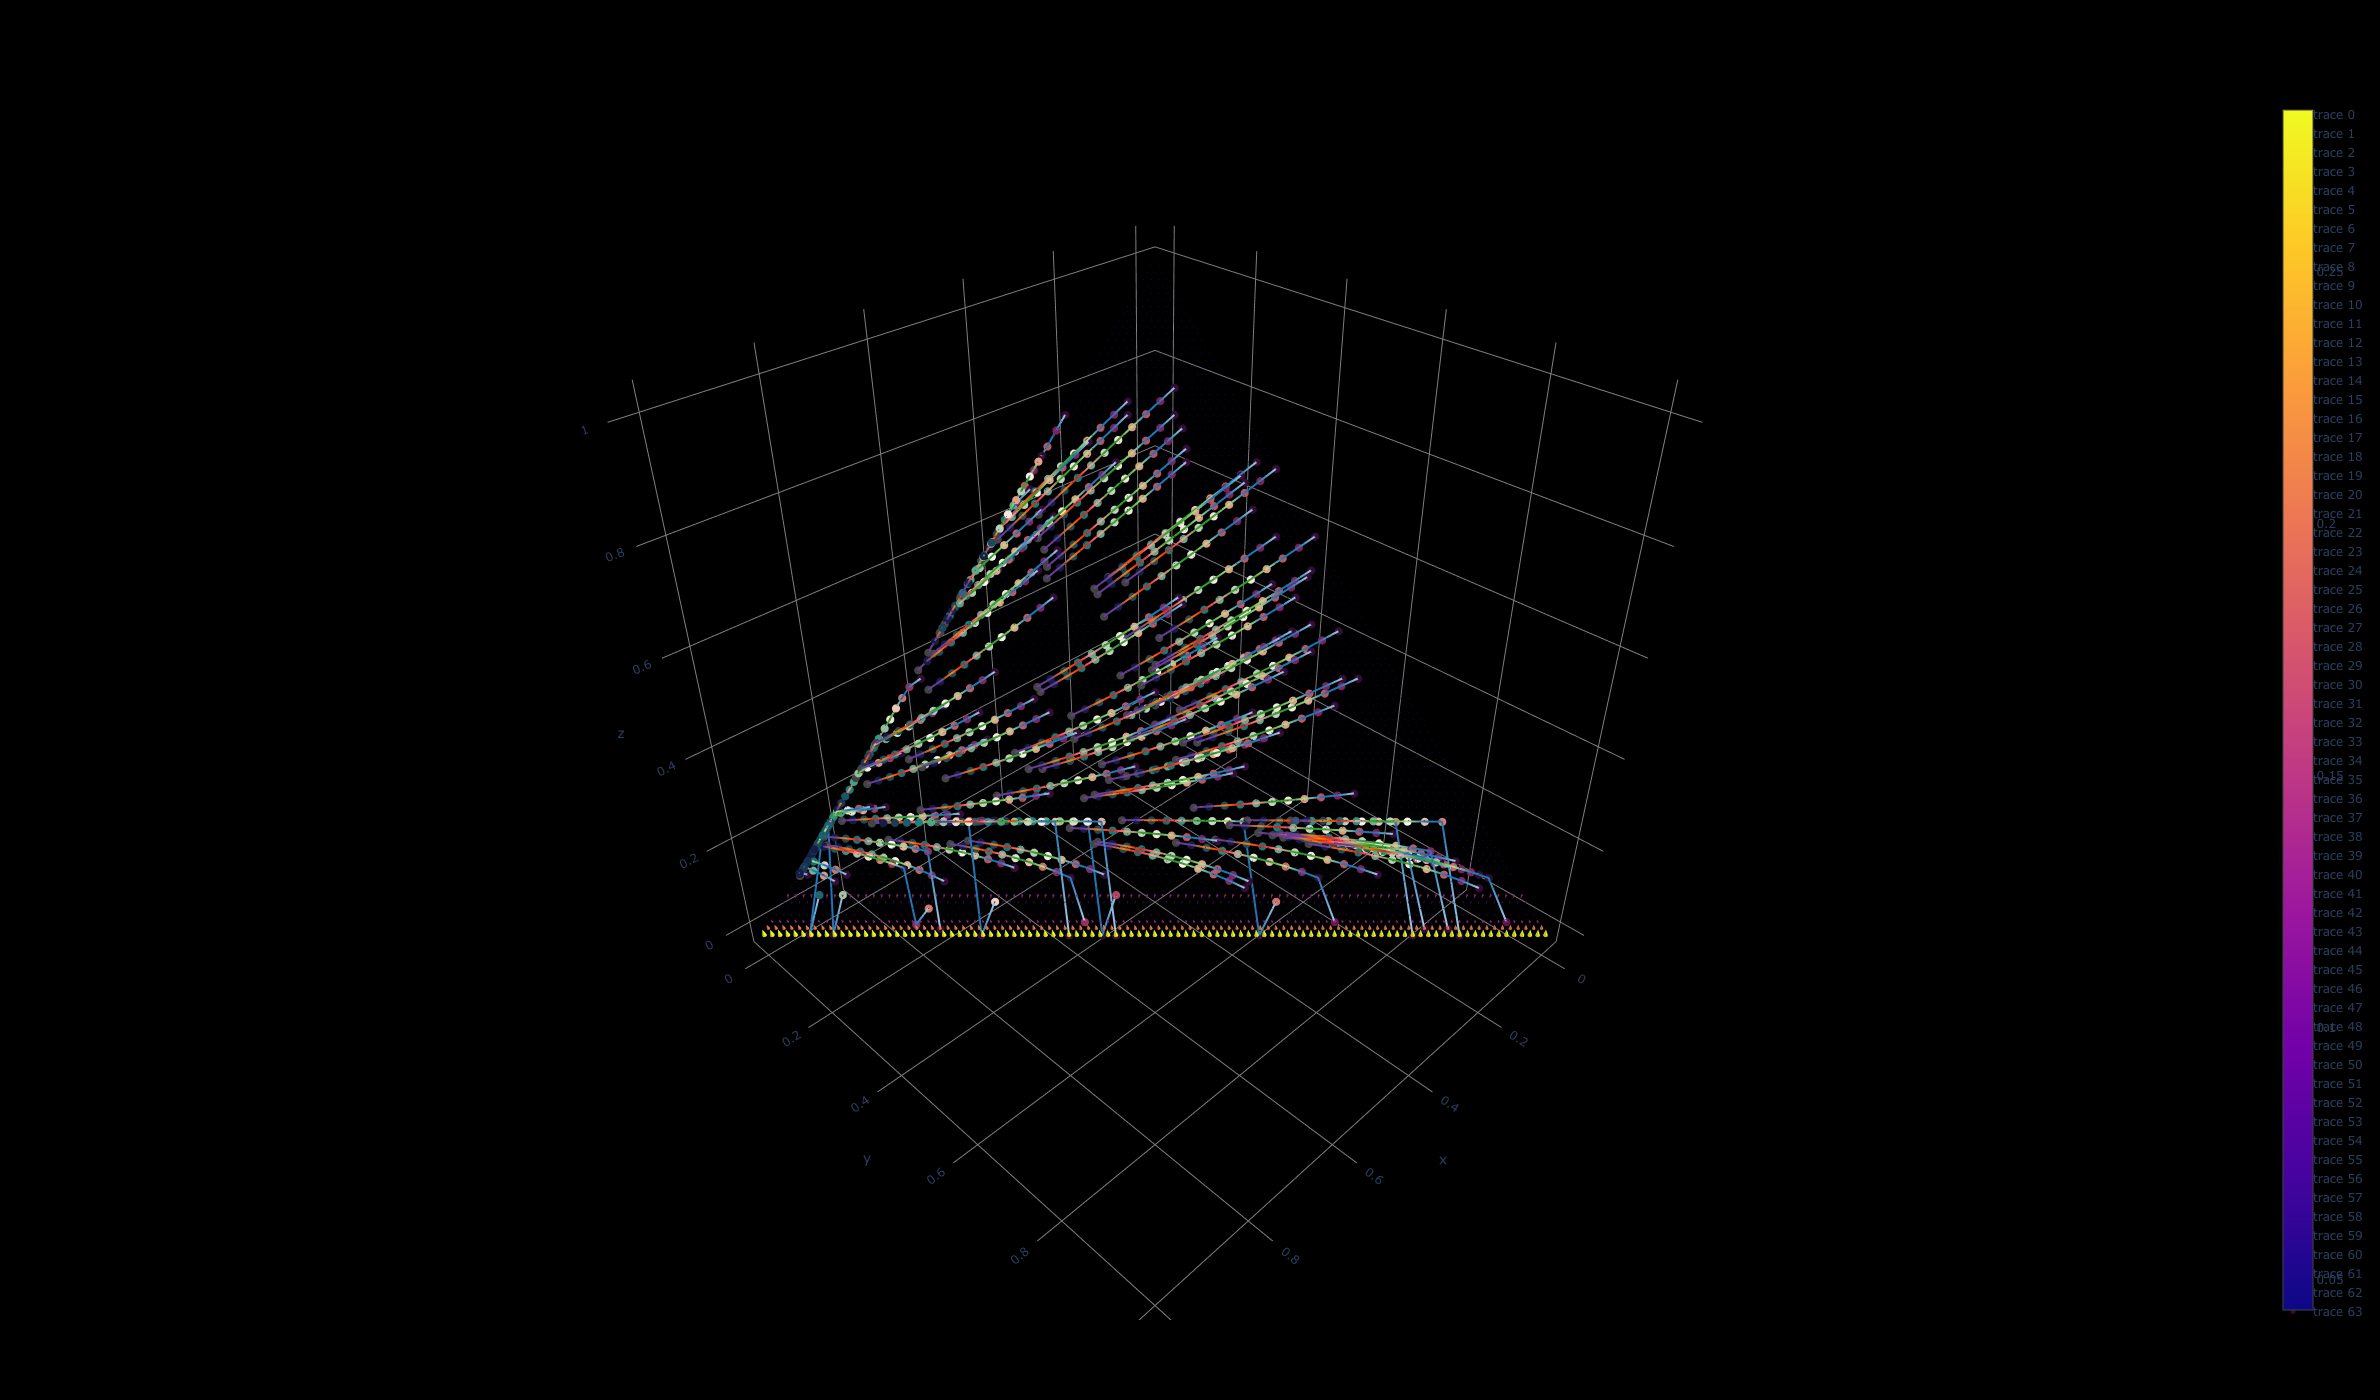

In [29]:
iterations = 10
cs =[]
data = []
num = 100
combos = []
def partitions(n, k):
    for c in itertools.combinations(range(n+k-1), k-1):
        yield [b-a-1 for a, b in zip((-1,)+c, c+(n+k-1,))]

for par in partitions(num, 3):
    combos.append(par)
    

cmain = []
xmain = []
ymain = []
zmain = []
initial_lr = 10
for j in tqdm(range(100)):
    #lr = initial_lr-(i*initial_lr/iterations)
    lr = 1
    selector = np.random.randint(1,len(combos), size=1)[0]
    x_ = combos[selector][0]/100
    y_ = combos[selector][1]/100
    z_ = combos[selector][2]/100
    x2s = [x_]
    y2s = [y_]
    z2s = [z_]
    cs = []
    for i in range(iterations):
        APR, ui, vi, wi,x2, y2, z2, projX, projY,projZ = calcAPR(x_,y_,z_, lr)
        x2s.append(projX)
        y2s.append(projY)
        z2s.append(projZ)
        cs.append(APR)
        x_ = projX
        y_ = projY
        z_ = projZ
    xmain += x2s
    ymain += y2s
    zmain += z2s 
    cmain += cs
    dots = go.Scatter3d(
                x=x2s,
                y=y2s,
                z=z2s,
                marker=dict(size=5,color=cs,colorscale=pl_curl),
                line=dict(color=[
          "rgb(166,206,227)",
          "rgb(31,120,180)",
          "rgb(31,120,180)",
          "rgb(178,223,138)",
          "rgb(51,160,44)",
          "rgb(51,160,44)",
          "rgb(251,154,153)",
          "rgb(227,26,28)",
          "rgb(255,127,0)",
          "rgb(106,61,154)",
          "rgb(106,61,154)"
        ],width=4)
    #             mode="markers"
                )  
    data.append(dots)
        
cones = dict(type='cone',
              x=xs,
              y=ys, 
              z=zs, 
              u=u, 
              v=v, 
              w=w, 
              sizemode='scaled',
              cauto=False,
              sizeref=1.2,
#               showscale=True,
#               colorscale=pl_curl, 
#               colorbar=dict(thickness=20, ticklen=4, len=0.75), 
              anchor='tail'
          )
data.append(cones)
fig = go.Figure(data=data)
fig.update_layout(
    width=1600,
    height=1400,
    paper_bgcolor="black",
    scene = dict(
                    xaxis = dict(
                         backgroundcolor="black",
                         gridcolor="rgb(128,128,128)",
                         showbackground=True,
                         zerolinecolor="rgb(128,128,128)",),
                    yaxis = dict(
                        backgroundcolor="black",
                        gridcolor="rgb(128,128,128)",
                        showbackground=True,
                        zerolinecolor="rgb(128,128,128)"),
                    zaxis = dict(
                        backgroundcolor="black",
                        gridcolor="rgb(128,128,128)",
                        showbackground=True,
                        zerolinecolor="rgb(128,128,128)",),)
)
fig.show()  

In [30]:
xyzc = list(zip(xmain, ymain, zmain, cmain))[iterations-1::iterations]
print(len(xyzc))
print(min(xyzc, key=lambda t: t[3]))
print(max(xyzc, key=lambda t: t[3]))

100
(0.906005859375, 0.0, 0.093994140625, 0.0203871833772473)
(0.33, 0.04, 0.63, 0.04519759274846003)


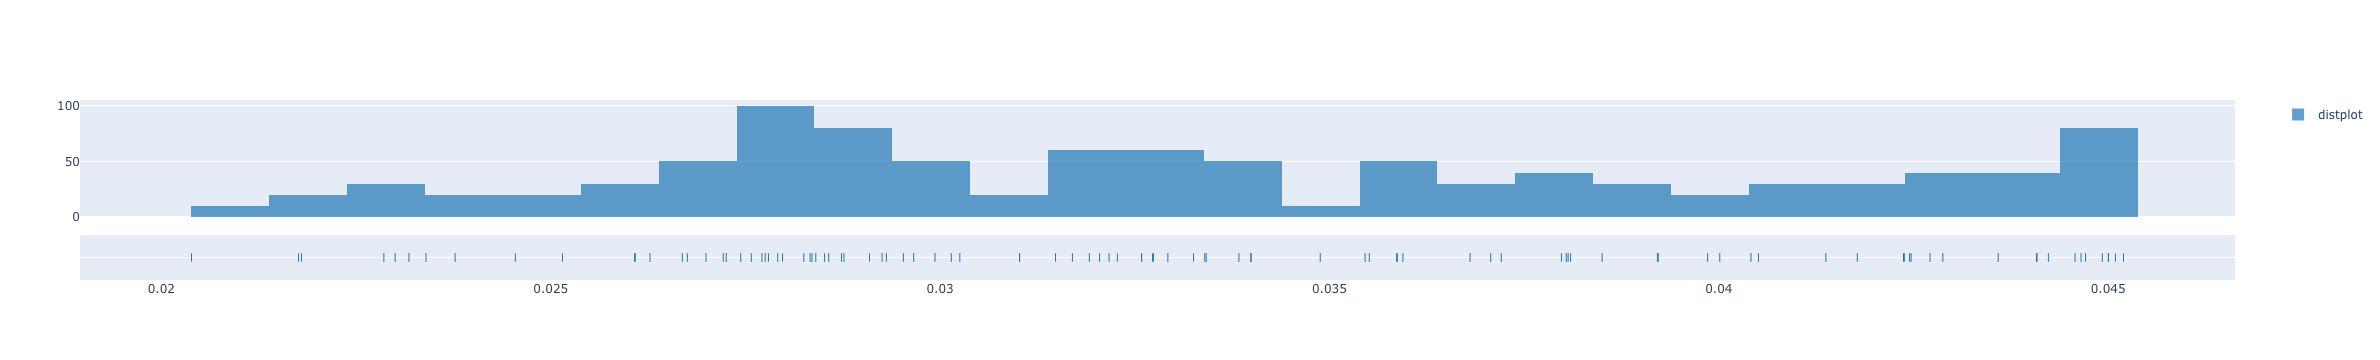

In [31]:
import plotly.figure_factory as ff

hist_data = [cmain[iterations-1::iterations]]
group_labels = ['distplot'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels, bin_size=0.001, show_curve=false)
fig.show()

In [32]:
# Note @ 1000 for this variable, the number of combos is 501501, so this can run pretty slow. I recommend NOT running this one for yourself, but you're welcome to it.
combos = []
num = 100# Down to one 10th of percent
def partitions(n, k):
    for c in itertools.combinations(range(n+k-1), k-1):
        yield [b-a-1 for a, b in zip((-1,)+c, c+(n+k-1,))]

for par in partitions(num, 3):
    combos.append(par)

In [37]:
import numpy as np

def get_return(combo):
    for j in range(len(combo)):
        combo[j] = combo[j] / num
    rate_fns = [solend_rate, port_rate, jet_rate]
    vars_ = [x, y, z]
    rates = [rate_fn.subs([(var, combo_)]) for rate_fn, var, combo_ in zip(rate_fns, vars_, combo)]
    return (combo, rates, sum(rates))

In [38]:
import multiprocess as mp

with mp.Pool() as p:
    returns = list(tqdm(p.imap_unordered(get_return, combos, 100), total=len(combos)))

max(returns, key=lambda t: t[2])    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5151/5151 [00:00<00:00, 8343.52it/s]


([0.97, 0.0, 0.03], [0.0432345501635167, 0, 0.00485547187950649], 0.0480900220430232)

For a naive brute force search that takes awhile, the results aren't very impressive compared to subgradient. The worst optimization via subgradient projection is .02% (in my test, if you rerun the above it will be different) worse than brute force search and the best optimization is fractionally better than the brute force. <br><br>

All this is to say, we have a low step count optimization technique on a relatively hard problem. Feel free to ask me questions, ask me to go into the math a bit more, etc. Feel free to tinker with values